### Import libraries and scripts

In [1]:
import deep_learning
import aux
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import io
import itertools
import keras
import sklearn
import datetime

/Users/fran/venv-tfmetal/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Install the required libraries

$ pip install -r requirements.txt

### Initial Data Preparation steps

Read data with Week consumptions (576 hour), next day consumption cluster label [0,21] and 24 consecutive consumption hour for next day

In [2]:
colnames_ = ["consumer_id","day_id"]
w_list = ['w' + str(x) for x in range(0,576)]
colnames_.extend(w_list)
colnames_.append("next_day_cluster")
d_list = ['d' + str(x) for x in range(0,24)]
colnames_.extend(d_list)
data = pd.read_csv ("../data/data_24diasprevios.csv",sep=";",header=None, names=colnames_)

In [3]:
data

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,1017,218,335,473,278,159,278,152,132,196,...,415,546,2413,2432,1525,626,470,645,468,581
1,1017,219,376,442,296,112,205,208,112,175,...,625,355,529,3525,521,644,720,893,590,540
2,1017,220,335,522,257,115,260,157,157,454,...,954,2141,3655,1543,644,547,673,662,461,497
3,1017,221,344,605,379,228,333,169,112,218,...,684,1225,501,2485,1699,1161,662,583,356,504
4,1017,222,324,340,395,111,128,256,135,130,...,411,1151,516,272,456,478,761,749,692,434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144128,7422,725,516,814,344,343,338,334,337,459,...,1079,1753,2286,2594,2316,1305,1866,1597,1320,513
144129,7422,726,797,620,264,256,256,258,256,386,...,576,566,565,1809,2248,2299,4453,2060,1492,1056
144130,7422,727,823,808,365,276,276,252,250,374,...,611,640,699,779,770,803,2724,1666,1253,493
144131,7422,728,991,574,237,249,238,229,226,343,...,1084,963,2001,4773,1846,2037,2597,1708,1850,514


In [40]:
pd.DataFrame(data.consumer_id.unique()).to_csv("consumer_ids.csv",index=False)

- split data in users df

In [4]:
dfs = dict(tuple(data.groupby('consumer_id')))
len (dfs)

288

In [5]:
dfs

{1017:      consumer_id  day_id   w0   w1   w2   w3   w4   w5   w6   w7  ...   d14  \
 0           1017     218  335  473  278  159  278  152  132  196  ...   415   
 1           1017     219  376  442  296  112  205  208  112  175  ...   625   
 2           1017     220  335  522  257  115  260  157  157  454  ...   954   
 3           1017     221  344  605  379  228  333  169  112  218  ...   684   
 4           1017     222  324  340  395  111  128  256  135  130  ...   411   
 ..           ...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
 456         1017     699  476  524  378  136  174  144  152  150  ...   389   
 457         1017     700  671  354  366  187  165  158  154  138  ...   371   
 458         1017     701  408  388  410  275  206  204  181  219  ...  1343   
 459         1017     728  534  431  462  337  265  312  274  293  ...   560   
 460         1017     729  438  450  449  300  304  339  241  183  ...  1317   
 
       d15   d16   d17   d18   d

In [6]:
dfs.values()

dict_values([     consumer_id  day_id   w0   w1   w2   w3   w4   w5   w6   w7  ...   d14  \
0           1017     218  335  473  278  159  278  152  132  196  ...   415   
1           1017     219  376  442  296  112  205  208  112  175  ...   625   
2           1017     220  335  522  257  115  260  157  157  454  ...   954   
3           1017     221  344  605  379  228  333  169  112  218  ...   684   
4           1017     222  324  340  395  111  128  256  135  130  ...   411   
..           ...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
456         1017     699  476  524  378  136  174  144  152  150  ...   389   
457         1017     700  671  354  366  187  165  158  154  138  ...   371   
458         1017     701  408  388  410  275  206  204  181  219  ...  1343   
459         1017     728  534  431  462  337  265  312  274  293  ...   560   
460         1017     729  438  450  449  300  304  339  241  183  ...  1317   

      d15   d16   d17   d18   d19   d2

### Extract slide windows of days for month and days images and remove 23 last files of consumption

In [8]:
dfs[6913]

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
132123,6913,218,148,178,138,182,134,314,213,540,...,310,354,287,736,462,522,413,1012,469,162
132124,6913,219,240,318,139,184,129,179,127,633,...,420,403,246,485,352,387,449,628,128,174
132125,6913,220,173,149,170,152,148,157,130,450,...,602,817,1074,987,476,376,352,891,130,170
132126,6913,221,174,145,180,128,177,128,155,1026,...,706,579,534,787,188,373,378,999,168,222
132127,6913,222,155,169,154,164,158,152,164,1230,...,369,2238,2602,625,545,404,1324,1067,1210,479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132605,6913,725,28,95,81,299,107,44,374,672,...,893,812,696,1308,1180,832,1080,711,365,329
132606,6913,726,26,107,27,379,35,113,312,678,...,765,667,1219,3093,813,630,808,695,575,236
132607,6913,727,109,39,128,265,112,27,387,824,...,1042,2022,1388,532,515,609,1030,396,299,330
132608,6913,728,130,69,83,345,40,100,266,1085,...,974,768,697,1201,722,669,777,513,153,114


In [9]:
res = dfs[1017][:-23]
res

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,1017,218,335,473,278,159,278,152,132,196,...,415,546,2413,2432,1525,626,470,645,468,581
1,1017,219,376,442,296,112,205,208,112,175,...,625,355,529,3525,521,644,720,893,590,540
2,1017,220,335,522,257,115,260,157,157,454,...,954,2141,3655,1543,644,547,673,662,461,497
3,1017,221,344,605,379,228,333,169,112,218,...,684,1225,501,2485,1699,1161,662,583,356,504
4,1017,222,324,340,395,111,128,256,135,130,...,411,1151,516,272,456,478,761,749,692,434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,1017,676,315,292,219,152,194,161,278,262,...,3185,832,621,589,727,2315,2108,1124,984,591
434,1017,677,317,320,208,179,298,145,147,158,...,376,364,557,523,573,770,916,899,780,412
435,1017,678,545,318,198,179,166,172,157,171,...,594,1958,4235,862,935,648,981,821,847,471
436,1017,679,480,290,215,136,185,131,165,151,...,932,1068,1867,3894,1167,977,938,720,750,648


### Prepare a list of dataframes(groups_resized) removing 23 last consumptions rows for each user and a dictionary for each user with day_id slide windows=24 (slide_windows_dictionary)

In [10]:
from numpy.lib.stride_tricks import sliding_window_view

#slide_windows_= []
groups_resized = []

slide_windows_dictionary = dict()

for key,value in dfs.items():
    
    id_user = key
    val = value
     
    slide_windows = sliding_window_view(val.day_id, 24)
    
    slide_windows_dictionary[id_user] = slide_windows
    
    #slide_windows = np.append (slide_windows,[id_user])
    
    #print(slide_windows)
    
    #slide_windows_.append(slide_windows)
   
    groups_resized.append(value[:-23])


In [11]:
slide_windows_dictionary[1017]

array([[218, 219, 220, ..., 239, 240, 241],
       [219, 220, 221, ..., 240, 241, 242],
       [220, 221, 222, ..., 241, 242, 243],
       ...,
       [678, 679, 680, ..., 699, 700, 701],
       [679, 680, 681, ..., 700, 701, 728],
       [680, 681, 682, ..., 701, 728, 729]])

In [12]:
groups_resized[0]

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,1017,218,335,473,278,159,278,152,132,196,...,415,546,2413,2432,1525,626,470,645,468,581
1,1017,219,376,442,296,112,205,208,112,175,...,625,355,529,3525,521,644,720,893,590,540
2,1017,220,335,522,257,115,260,157,157,454,...,954,2141,3655,1543,644,547,673,662,461,497
3,1017,221,344,605,379,228,333,169,112,218,...,684,1225,501,2485,1699,1161,662,583,356,504
4,1017,222,324,340,395,111,128,256,135,130,...,411,1151,516,272,456,478,761,749,692,434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,1017,676,315,292,219,152,194,161,278,262,...,3185,832,621,589,727,2315,2108,1124,984,591
434,1017,677,317,320,208,179,298,145,147,158,...,376,364,557,523,573,770,916,899,780,412
435,1017,678,545,318,198,179,166,172,157,171,...,594,1958,4235,862,935,648,981,821,847,471
436,1017,679,480,290,215,136,185,131,165,151,...,932,1068,1867,3894,1167,977,938,720,750,648


In [13]:
len(groups_resized)

288

- Only one dataframe with consumptions processed

In [14]:

names = data.columns.values
consumption_full_df = pd.DataFrame(columns=names)
for r in groups_resized:
    frames = [consumption_full_df,r]
    consumption_full_df = pd.concat(frames, ignore_index=True)
 

In [18]:
consumption_full_df

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,1017,218,335,473,278,159,278,152,132,196,...,415,546,2413,2432,1525,626,470,645,468,581
1,1017,219,376,442,296,112,205,208,112,175,...,625,355,529,3525,521,644,720,893,590,540
2,1017,220,335,522,257,115,260,157,157,454,...,954,2141,3655,1543,644,547,673,662,461,497
3,1017,221,344,605,379,228,333,169,112,218,...,684,1225,501,2485,1699,1161,662,583,356,504
4,1017,222,324,340,395,111,128,256,135,130,...,411,1151,516,272,456,478,761,749,692,434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137504,7422,702,908,567,228,249,242,227,222,904,...,993,1173,1598,3007,2436,1947,2127,1321,1169,899
137505,7422,703,634,449,229,230,229,210,153,922,...,971,1295,1250,3443,1958,2369,2117,1492,576,516
137506,7422,704,434,625,225,159,229,227,222,593,...,808,1472,1103,3294,1913,2508,2177,1327,810,373
137507,7422,705,819,754,231,230,261,231,226,352,...,1138,1532,1774,3993,1690,1746,1991,1502,858,1698


In [17]:
consumption_full_df[consumption_full_df.consumer_id==6913]

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
126051,6913,218,148,178,138,182,134,314,213,540,...,310,354,287,736,462,522,413,1012,469,162
126052,6913,219,240,318,139,184,129,179,127,633,...,420,403,246,485,352,387,449,628,128,174
126053,6913,220,173,149,170,152,148,157,130,450,...,602,817,1074,987,476,376,352,891,130,170
126054,6913,221,174,145,180,128,177,128,155,1026,...,706,579,534,787,188,373,378,999,168,222
126055,6913,222,155,169,154,164,158,152,164,1230,...,369,2238,2602,625,545,404,1324,1067,1210,479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126510,6913,677,79,82,138,27,133,68,158,1158,...,1447,1326,2837,1139,1706,685,1002,580,592,285
126511,6913,678,100,76,48,97,99,35,110,635,...,950,1751,2871,1068,922,748,626,687,49,116
126512,6913,679,51,68,93,93,37,83,227,818,...,990,1920,4032,882,1100,729,761,895,641,254
126513,6913,680,93,59,73,94,96,27,166,822,...,751,1101,2122,1827,764,789,736,719,101,124


In [19]:
consumption_full_df.to_csv("../data/filtrado_definitivo_consumos.csv",index=False)

In [20]:
names = []
for i in range(24):
    names.append("d"+str(i))
names

['d0',
 'd1',
 'd2',
 'd3',
 'd4',
 'd5',
 'd6',
 'd7',
 'd8',
 'd9',
 'd10',
 'd11',
 'd12',
 'd13',
 'd14',
 'd15',
 'd16',
 'd17',
 'd18',
 'd19',
 'd20',
 'd21',
 'd22',
 'd23']

- Month and day data

### View consumers observations


In [120]:
data.groupby("consumer_id").size()

consumer_id
1017    438
1022    464
1099    464
1102    489
1136    489
       ... 
7336    489
7342    489
7381    489
7387    489
7422    489
Length: 288, dtype: int64

In [74]:
data[data.consumer_id==6913]

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
132123,6913,218,148,178,138,182,134,314,213,540,...,310,354,287,736,462,522,413,1012,469,162
132124,6913,219,240,318,139,184,129,179,127,633,...,420,403,246,485,352,387,449,628,128,174
132125,6913,220,173,149,170,152,148,157,130,450,...,602,817,1074,987,476,376,352,891,130,170
132126,6913,221,174,145,180,128,177,128,155,1026,...,706,579,534,787,188,373,378,999,168,222
132127,6913,222,155,169,154,164,158,152,164,1230,...,369,2238,2602,625,545,404,1324,1067,1210,479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132605,6913,725,28,95,81,299,107,44,374,672,...,893,812,696,1308,1180,832,1080,711,365,329
132606,6913,726,26,107,27,379,35,113,312,678,...,765,667,1219,3093,813,630,808,695,575,236
132607,6913,727,109,39,128,265,112,27,387,824,...,1042,2022,1388,532,515,609,1030,396,299,330
132608,6913,728,130,69,83,345,40,100,266,1085,...,974,768,697,1201,722,669,777,513,153,114


### Data splitting

In [21]:
from sklearn.model_selection import train_test_split

consumers_ids = data.consumer_id.unique()

consumers_train, consumers_test = train_test_split(consumers_ids, test_size=0.1, random_state=1)

consumers_train, consumers_val = train_test_split(consumers_train, test_size=0.20, random_state=1)


In [33]:
consumers_test[consumers_test==6913]

array([6913])

### dataset de entrenamiento, validación y test

In [26]:
train_ds = consumption_full_df[consumption_full_df.consumer_id.isin(consumers_train)]
train_ds

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,1017,218,335,473,278,159,278,152,132,196,...,415,546,2413,2432,1525,626,470,645,468,581
1,1017,219,376,442,296,112,205,208,112,175,...,625,355,529,3525,521,644,720,893,590,540
2,1017,220,335,522,257,115,260,157,157,454,...,954,2141,3655,1543,644,547,673,662,461,497
3,1017,221,344,605,379,228,333,169,112,218,...,684,1225,501,2485,1699,1161,662,583,356,504
4,1017,222,324,340,395,111,128,256,135,130,...,411,1151,516,272,456,478,761,749,692,434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137015,7387,702,1081,704,258,161,117,113,135,417,...,605,5422,381,333,382,1599,1600,2791,1102,1067
137016,7387,703,1273,1010,227,232,195,93,124,143,...,1371,567,622,1150,1360,1326,1660,1163,852,320
137017,7387,704,1232,1587,220,139,126,82,114,133,...,126,129,181,1348,3584,1291,1102,1084,915,605
137018,7387,705,841,213,375,255,254,213,219,511,...,67,150,64,3497,1319,1223,1044,1382,1086,795


In [27]:
val_ds = consumption_full_df[consumption_full_df.consumer_id.isin(consumers_val)]
val_ds

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
2344,1225,218,576,652,680,617,572,371,319,694,...,379,534,782,713,533,570,2004,649,751,676
2345,1225,219,680,628,651,631,562,427,332,705,...,326,802,585,663,465,293,357,411,1323,794
2346,1225,220,688,617,693,649,562,357,332,560,...,313,346,648,583,735,498,820,609,503,630
2347,1225,221,672,694,688,669,625,293,313,676,...,339,301,1235,580,527,575,579,1018,659,627
2348,1225,222,696,677,657,691,622,302,344,619,...,446,619,1114,986,668,716,694,998,755,813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134570,7313,702,101,78,104,143,80,372,83,263,...,716,471,881,2084,1174,997,8119,698,801,1305
134571,7313,703,155,80,101,78,104,79,317,212,...,718,953,1981,3094,3381,1321,908,611,1015,729
134572,7313,704,144,113,85,113,85,97,328,510,...,1822,646,1115,1329,1628,1376,2320,1223,1292,729
134573,7313,705,442,126,193,408,134,141,116,143,...,577,769,1131,1224,1281,1519,822,1719,1428,1365


In [28]:
test_ds = consumption_full_df[consumption_full_df.consumer_id.isin(consumers_test)]
test_ds

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
5151,1277,218,1097,878,143,101,71,74,98,1088,...,12,12,12,12,12,12,12,12,15,32
5152,1277,219,568,527,150,102,77,73,75,191,...,12,12,12,12,12,12,12,12,23,56
5153,1277,220,92,93,126,2389,422,81,70,276,...,12,12,12,12,12,12,12,12,23,56
5154,1277,221,22,14,23,12,12,12,12,12,...,12,12,12,12,12,12,12,12,15,40
5155,1277,222,51,15,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,15,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137504,7422,702,908,567,228,249,242,227,222,904,...,993,1173,1598,3007,2436,1947,2127,1321,1169,899
137505,7422,703,634,449,229,230,229,210,153,922,...,971,1295,1250,3443,1958,2369,2117,1492,576,516
137506,7422,704,434,625,225,159,229,227,222,593,...,808,1472,1103,3294,1913,2508,2177,1327,810,373
137507,7422,705,819,754,231,230,261,231,226,352,...,1138,1532,1774,3993,1690,1746,1991,1502,858,1698


In [29]:
train_ds

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,1017,218,335,473,278,159,278,152,132,196,...,415,546,2413,2432,1525,626,470,645,468,581
1,1017,219,376,442,296,112,205,208,112,175,...,625,355,529,3525,521,644,720,893,590,540
2,1017,220,335,522,257,115,260,157,157,454,...,954,2141,3655,1543,644,547,673,662,461,497
3,1017,221,344,605,379,228,333,169,112,218,...,684,1225,501,2485,1699,1161,662,583,356,504
4,1017,222,324,340,395,111,128,256,135,130,...,411,1151,516,272,456,478,761,749,692,434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137015,7387,702,1081,704,258,161,117,113,135,417,...,605,5422,381,333,382,1599,1600,2791,1102,1067
137016,7387,703,1273,1010,227,232,195,93,124,143,...,1371,567,622,1150,1360,1326,1660,1163,852,320
137017,7387,704,1232,1587,220,139,126,82,114,133,...,126,129,181,1348,3584,1291,1102,1084,915,605
137018,7387,705,841,213,375,255,254,213,219,511,...,67,150,64,3497,1319,1223,1044,1382,1086,795


In [35]:
test_ds

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
5151,1277,218,1097,878,143,101,71,74,98,1088,...,12,12,12,12,12,12,12,12,15,32
5152,1277,219,568,527,150,102,77,73,75,191,...,12,12,12,12,12,12,12,12,23,56
5153,1277,220,92,93,126,2389,422,81,70,276,...,12,12,12,12,12,12,12,12,23,56
5154,1277,221,22,14,23,12,12,12,12,12,...,12,12,12,12,12,12,12,12,15,40
5155,1277,222,51,15,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,15,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137504,7422,702,908,567,228,249,242,227,222,904,...,993,1173,1598,3007,2436,1947,2127,1321,1169,899
137505,7422,703,634,449,229,230,229,210,153,922,...,971,1295,1250,3443,1958,2369,2117,1492,576,516
137506,7422,704,434,625,225,159,229,227,222,593,...,808,1472,1103,3294,1913,2508,2177,1327,810,373
137507,7422,705,819,754,231,230,261,231,226,352,...,1138,1532,1774,3993,1690,1746,1991,1502,858,1698


--------------- calculation days and month datasets ---------

In [25]:
#slide train
slide_train = [d[1] for d in slide_windows_dictionary.items() if d[0] in consumers_train]

names = []
for i in range(24):
    names.append("d"+str(i))
slide_train_df = pd.DataFrame(np.concatenate(slide_train), columns = names) 


#slide val
slide_val = [d[1] for d in slide_windows_dictionary.items() if d[0] in consumers_val]

names = []
for i in range(24):
    names.append("d"+str(i))
slide_val_df = pd.DataFrame(np.concatenate(slide_val), columns = names) 

#slide test
slide_test = [d[1] for d in slide_windows_dictionary.items() if d[0] in consumers_test]

names = []
for i in range(24):
    names.append("d"+str(i))
slide_test_df = pd.DataFrame(np.concatenate(slide_test), columns = names) 





In [26]:
slide_test_df

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,218,219,220,221,222,223,224,225,226,227,...,232,233,234,235,236,237,238,239,240,241
1,219,220,221,222,223,224,225,226,227,228,...,233,234,235,236,237,238,239,240,241,242
2,220,221,222,223,224,225,226,227,228,229,...,234,235,236,237,238,239,240,241,242,243
3,221,222,223,224,225,226,227,228,229,230,...,235,236,237,238,239,240,241,242,243,244
4,222,223,224,225,226,227,228,229,230,231,...,236,237,238,239,240,241,242,243,244,245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13896,702,703,704,705,706,707,708,709,710,711,...,716,717,718,719,720,721,722,723,724,725
13897,703,704,705,706,707,708,709,710,711,712,...,717,718,719,720,721,722,723,724,725,726
13898,704,705,706,707,708,709,710,711,712,713,...,718,719,720,721,722,723,724,725,726,727
13899,705,706,707,708,709,710,711,712,713,714,...,719,720,721,722,723,724,725,726,727,728


In [27]:
origin_date = datetime.datetime(2009, 1, 1) 

In [28]:
origin_date

datetime.datetime(2009, 1, 1, 0, 0)

In [29]:
def get_month_for_consumption_day(x):
    bla = origin_date + pd.to_timedelta(x,unit="days")
    return bla.dt.month

In [30]:
def get_day_of_week_for_consumption_day(x):
    bla = origin_date + pd.to_timedelta(x,unit="days")
    return bla.dt.weekday

In [31]:
month_for_consumption_days_train = slide_train_df.apply( 
    get_month_for_consumption_day )

month_for_consumption_days_val = slide_val_df.apply( 
    get_month_for_consumption_day )

month_for_consumption_days_test = slide_test_df.apply( 
    get_month_for_consumption_day )

days_for_consumption_days_train = slide_train_df.apply( 
    get_day_of_week_for_consumption_day )

days_for_consumption_days_val = slide_val_df.apply( 
    get_day_of_week_for_consumption_day )

days_for_consumption_days_test = slide_test_df.apply( 
    get_day_of_week_for_consumption_day )


In [32]:
days_for_consumption_days_test

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,4,5,6,0,1,2,3,4,5,6,...,4,5,6,0,1,2,3,4,5,6
1,5,6,0,1,2,3,4,5,6,0,...,5,6,0,1,2,3,4,5,6,0
2,6,0,1,2,3,4,5,6,0,1,...,6,0,1,2,3,4,5,6,0,1
3,0,1,2,3,4,5,6,0,1,2,...,0,1,2,3,4,5,6,0,1,2
4,1,2,3,4,5,6,0,1,2,3,...,1,2,3,4,5,6,0,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13896,5,6,0,1,2,3,4,5,6,0,...,5,6,0,1,2,3,4,5,6,0
13897,6,0,1,2,3,4,5,6,0,1,...,6,0,1,2,3,4,5,6,0,1
13898,0,1,2,3,4,5,6,0,1,2,...,0,1,2,3,4,5,6,0,1,2
13899,1,2,3,4,5,6,0,1,2,3,...,1,2,3,4,5,6,0,1,2,3


In [33]:
month_for_consumption_days_train[month_for_consumption_days_train == 7] = 6
month_for_consumption_days_train[month_for_consumption_days_train == 8] = 5
month_for_consumption_days_train[month_for_consumption_days_train == 9] = 4
month_for_consumption_days_train[month_for_consumption_days_train == 10] = 3
month_for_consumption_days_train[month_for_consumption_days_train == 11] = 2
month_for_consumption_days_train[month_for_consumption_days_train == 12] = 1

month_for_consumption_days_val[month_for_consumption_days_val == 7] = 6
month_for_consumption_days_val[month_for_consumption_days_val == 8] = 5
month_for_consumption_days_val[month_for_consumption_days_val == 9] = 4
month_for_consumption_days_val[month_for_consumption_days_val == 10] = 3
month_for_consumption_days_val[month_for_consumption_days_val == 11] = 2
month_for_consumption_days_val[month_for_consumption_days_val == 12] = 1

month_for_consumption_days_test[month_for_consumption_days_test == 7] = 6
month_for_consumption_days_test[month_for_consumption_days_test == 8] = 5
month_for_consumption_days_test[month_for_consumption_days_test == 9] = 4
month_for_consumption_days_test[month_for_consumption_days_test == 10] = 3
month_for_consumption_days_test[month_for_consumption_days_test == 11] = 2
month_for_consumption_days_test[month_for_consumption_days_test == 12] = 1

In [34]:
month_for_consumption_days_train

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
1,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
2,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,4
3,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,4,4
4,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99008,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
99009,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
99010,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
99011,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


- imágenes de meses  y días :)

### Save datasets train, test and val for day and month images (6 ds)

In [35]:
month_for_consumption_days_train.to_csv("../data/month_for_consumption_days_train.csv",index=False)
month_for_consumption_days_val.to_csv("../data/month_for_consumption_days_val.csv",index=False)
month_for_consumption_days_test.to_csv("../data/month_for_consumption_days_test.csv",index=False)

days_for_consumption_days_train.to_csv("../data/days_for_consumption_days_train.csv",index=False)
days_for_consumption_days_val.to_csv("../data/days_for_consumption_days_val.csv",index=False)
days_for_consumption_days_test.to_csv("../data/days_for_consumption_days_test.csv",index=False)

--- month and days datasets for multiconsumer (train, val and test)

In [3]:
month_for_consumption_days_train = pd.read_csv ("../data/month_for_consumption_days_train.csv",sep=",")
month_for_consumption_days_val = pd.read_csv ("../data/month_for_consumption_days_val.csv",sep=",")
month_for_consumption_days_test = pd.read_csv ("../data/month_for_consumption_days_test.csv",sep=",")

days_for_consumption_days_train = pd.read_csv ("../data/days_for_consumption_days_train.csv",sep=",")
days_for_consumption_days_val = pd.read_csv ("../data/days_for_consumption_days_val.csv",sep=",")
days_for_consumption_days_test = pd.read_csv ("../data/days_for_consumption_days_test.csv",sep=",")

### Prepare consumptions and next day consumptions datasets for train, test and val (6)

In [36]:

data_consumptions_train = train_ds.iloc[:,2:] 
data_consumptions_nexd_day_train = data_consumptions_train.iloc[:,577:602]
data_consumptions_train = data_consumptions_train.iloc[: , :-25]

data_consumptions_val = val_ds.iloc[:,2:] 
data_consumptions_nexd_day_val = data_consumptions_val.iloc[:,577:602]
data_consumptions_val = data_consumptions_val.iloc[: , :-25]

data_consumptions_test = test_ds.iloc[:,2:] 
data_consumptions_nexd_day_test = data_consumptions_test.iloc[:,577:602]
data_consumptions_test = data_consumptions_test.iloc[: , :-25]

In [37]:
train_ds

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,1017,218,335,473,278,159,278,152,132,196,...,415,546,2413,2432,1525,626,470,645,468,581
1,1017,219,376,442,296,112,205,208,112,175,...,625,355,529,3525,521,644,720,893,590,540
2,1017,220,335,522,257,115,260,157,157,454,...,954,2141,3655,1543,644,547,673,662,461,497
3,1017,221,344,605,379,228,333,169,112,218,...,684,1225,501,2485,1699,1161,662,583,356,504
4,1017,222,324,340,395,111,128,256,135,130,...,411,1151,516,272,456,478,761,749,692,434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137015,7387,702,1081,704,258,161,117,113,135,417,...,605,5422,381,333,382,1599,1600,2791,1102,1067
137016,7387,703,1273,1010,227,232,195,93,124,143,...,1371,567,622,1150,1360,1326,1660,1163,852,320
137017,7387,704,1232,1587,220,139,126,82,114,133,...,126,129,181,1348,3584,1291,1102,1084,915,605
137018,7387,705,841,213,375,255,254,213,219,511,...,67,150,64,3497,1319,1223,1044,1382,1086,795


In [38]:
data_consumptions_nexd_day_train

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,527,460,406,209,329,156,252,151,324,828,...,415,546,2413,2432,1525,626,470,645,468,581
1,382,464,360,192,242,166,248,146,254,737,...,625,355,529,3525,521,644,720,893,590,540
2,419,548,307,262,172,195,198,173,218,279,...,954,2141,3655,1543,644,547,673,662,461,497
3,404,467,363,254,151,230,242,376,410,1437,...,684,1225,501,2485,1699,1161,662,583,356,504
4,347,480,255,230,191,250,156,200,267,1482,...,411,1151,516,272,456,478,761,749,692,434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137015,657,902,601,73,148,76,683,102,175,98,...,605,5422,381,333,382,1599,1600,2791,1102,1067
137016,1228,2937,2139,251,307,106,201,111,195,393,...,1371,567,622,1150,1360,1326,1660,1163,852,320
137017,818,637,112,174,151,125,2751,111,221,107,...,126,129,181,1348,3584,1291,1102,1084,915,605
137018,220,930,135,115,144,80,724,78,188,62,...,67,150,64,3497,1319,1223,1044,1382,1086,795


# Image generation

- example one image

In [39]:
dow_first_row = days_for_consumption_days_train.iloc[666].to_numpy()
dow_img = dow_first_row
for i in range (0,23):
    dow_img = np.column_stack((dow_img,dow_first_row))
dow_img

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5],
       [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4],
       [5, 5, 5, 5, 5

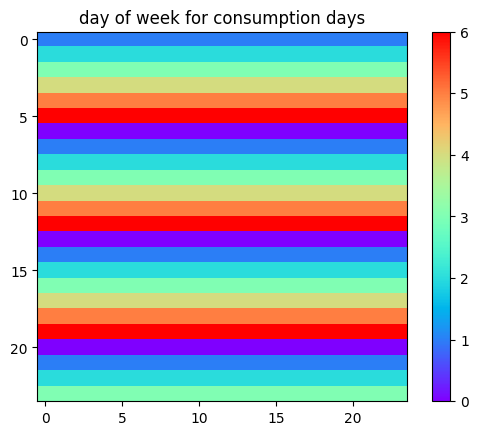

In [40]:
plt.imshow(dow_img,cmap = 'rainbow')
plt.title("day of week for consumption days")
plt.colorbar()

In [41]:
month_first_row = month_for_consumption_days_train.iloc[666].to_numpy()
month_img = month_first_row
for i in range (0,23):
    month_img = np.column_stack((month_img,month_first_row))
month_img

array([[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4],
       [4, 4, 4, 4, 4

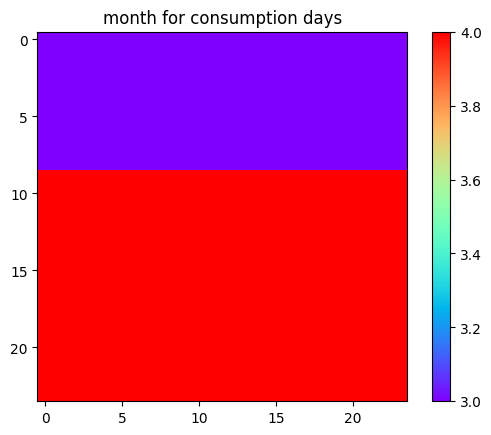

In [42]:
plt.imshow(month_img,cmap = 'rainbow')
plt.title("month for consumption days")
plt.colorbar()

### Normalize consumptions datasets

In [55]:
max_val = data.drop(['next_day_cluster','day_id','consumer_id'], axis=1).to_numpy().max()
min_val = data.drop(['next_day_cluster','day_id','consumer_id'], axis=1).to_numpy().min()
max_val

14979

In [44]:
def normalize_row(x):
    normalized = (x - min_val) / (max_val - min_val)
    return normalized


In [45]:
data_consumptions_train = data_consumptions_train.apply(
    normalize_row,
    axis=1)
data_consumptions_train

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w566,w567,w568,w569,w570,w571,w572,w573,w574,w575
0,0.022299,0.031513,0.018494,0.010549,0.018494,0.010081,0.008746,0.013019,0.019696,0.130925,...,0.025304,0.028909,0.093270,0.197823,0.049940,0.064628,0.052811,0.050073,0.041861,0.037588
1,0.025037,0.029443,0.019696,0.007411,0.013620,0.013820,0.007411,0.011617,0.023701,0.066230,...,0.027641,0.036387,0.161036,0.162305,0.101749,0.041728,0.031313,0.042996,0.031179,0.038723
2,0.022299,0.034784,0.017092,0.007611,0.017292,0.010415,0.010415,0.030244,0.051743,0.022566,...,0.041661,0.023635,0.035252,0.235278,0.034718,0.042930,0.048004,0.059554,0.039324,0.035986
3,0.022900,0.040326,0.025237,0.015156,0.022166,0.011216,0.007411,0.014488,0.012619,0.049606,...,0.063627,0.142876,0.243958,0.102951,0.042930,0.036453,0.044866,0.044131,0.030712,0.033115
4,0.021565,0.022633,0.026305,0.007344,0.008479,0.017025,0.008946,0.008613,0.014021,0.016691,...,0.045600,0.081720,0.033382,0.165843,0.113366,0.077447,0.044131,0.038857,0.023701,0.033583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137015,0.072106,0.046936,0.017158,0.010682,0.007745,0.007478,0.008946,0.027774,0.015022,0.004740,...,0.009948,0.008946,0.029310,0.066831,0.212111,0.071905,0.075711,0.056149,0.043864,0.048471
137016,0.084925,0.067365,0.015089,0.015423,0.012952,0.006142,0.008212,0.009481,0.007611,0.006476,...,0.040326,0.361931,0.025371,0.022166,0.025437,0.106690,0.106757,0.186273,0.073508,0.071171
137017,0.082187,0.105889,0.014621,0.009214,0.008346,0.005408,0.007544,0.008813,0.008279,0.005742,...,0.091467,0.037789,0.041461,0.076713,0.090733,0.088463,0.110762,0.077580,0.056817,0.021298
137018,0.056082,0.014154,0.024970,0.016958,0.016891,0.014154,0.014555,0.034050,0.010215,0.006877,...,0.008346,0.008546,0.012018,0.089932,0.239218,0.086126,0.073508,0.072306,0.061023,0.040326


In [46]:
data_consumptions_val = data_consumptions_val.apply(
    normalize_row,
    axis=1)
data_consumptions_val

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w566,w567,w568,w569,w570,w571,w572,w573,w574,w575
2344,0.038390,0.043464,0.045333,0.041127,0.038123,0.024703,0.021231,0.046268,0.081653,0.046134,...,0.026105,0.054146,0.039458,0.041661,0.036320,0.038991,0.060756,0.048938,0.049072,0.045801
2345,0.045333,0.041861,0.043397,0.042062,0.037455,0.028442,0.022099,0.047002,0.106757,0.043263,...,0.025237,0.035586,0.052143,0.047536,0.035519,0.037989,0.133729,0.043263,0.050073,0.045066
2346,0.045867,0.041127,0.046201,0.043263,0.037455,0.023768,0.022099,0.037321,0.038390,0.080785,...,0.021698,0.053478,0.038991,0.044198,0.030979,0.019495,0.023768,0.027373,0.088263,0.052944
2347,0.044799,0.046268,0.045867,0.044599,0.041661,0.019495,0.020831,0.045066,0.083456,0.052277,...,0.020831,0.023034,0.043197,0.038857,0.049005,0.033182,0.054680,0.040593,0.033516,0.041995
2348,0.046401,0.045133,0.043798,0.046068,0.041461,0.020096,0.022900,0.041261,0.057618,0.075511,...,0.022566,0.020029,0.082388,0.038657,0.035118,0.038323,0.038590,0.067900,0.043931,0.041795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134570,0.006676,0.005141,0.006877,0.009481,0.005274,0.024770,0.005475,0.017492,0.015423,0.014154,...,0.043063,0.056817,0.056483,0.054814,0.079316,0.072840,0.069769,0.315196,0.063894,0.048605
134571,0.010282,0.005274,0.006676,0.005141,0.006877,0.005208,0.021098,0.014087,0.005007,0.013887,...,0.047737,0.031379,0.058753,0.139071,0.078315,0.066498,0.541995,0.046535,0.053412,0.087061
134572,0.009547,0.007478,0.005608,0.007478,0.005608,0.006409,0.021832,0.033983,0.005675,0.006543,...,0.047870,0.063560,0.132194,0.206503,0.225664,0.088129,0.060555,0.040726,0.067699,0.048605
134573,0.029443,0.008346,0.012819,0.027173,0.008880,0.009347,0.007678,0.009481,0.044666,0.016491,...,0.121578,0.043063,0.074376,0.088663,0.108626,0.091801,0.154827,0.081586,0.086193,0.048605


In [47]:
data_consumptions_test = data_consumptions_test.apply(
    normalize_row,
    axis=1)
data_consumptions_test

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w566,w567,w568,w569,w570,w571,w572,w573,w574,w575
5151,0.073174,0.058553,0.009481,0.006676,0.004674,0.004874,0.006476,0.072573,0.113233,0.075444,...,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000935,0.003806
5152,0.037856,0.035118,0.009948,0.006743,0.005074,0.004807,0.004941,0.012685,0.090666,0.058553,...,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000935,0.002070
5153,0.006076,0.006142,0.008346,0.159434,0.028108,0.005341,0.004607,0.018360,0.195086,0.043798,...,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.001469,0.003672
5154,0.001402,0.000868,0.001469,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,...,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.001469,0.003672
5155,0.003338,0.000935,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,...,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000935,0.002604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137504,0.060555,0.037789,0.015156,0.016558,0.016090,0.015089,0.014755,0.060288,0.023835,0.039391,...,0.078849,0.096942,0.101682,0.244492,0.160302,0.130725,0.136400,0.082855,0.056483,0.052477
137505,0.042262,0.029911,0.015222,0.015289,0.015222,0.013954,0.010148,0.061490,0.023635,0.036053,...,0.066230,0.078248,0.106623,0.200694,0.162572,0.129924,0.141942,0.088129,0.077981,0.059955
137506,0.028909,0.041661,0.014955,0.010549,0.015222,0.015089,0.014755,0.039525,0.025371,0.042663,...,0.064762,0.086393,0.083389,0.229804,0.130658,0.158099,0.141274,0.099546,0.038390,0.034384
137507,0.054613,0.050274,0.015356,0.015289,0.017359,0.015356,0.015022,0.023434,0.014621,0.011884,...,0.053879,0.098211,0.073575,0.219856,0.127654,0.167379,0.145280,0.088530,0.054013,0.024836


In [ ]:
2+2

### Save consumptions and next day consumptions data

In [48]:
data_consumptions_train.to_csv("../data/data_consumptions_train.csv",index=False)
data_consumptions_val.to_csv("../data/data_consumptions_val.csv",index=False)
data_consumptions_test.to_csv("../data/data_consumptions_test.csv",index=False)

data_consumptions_nexd_day_train.to_csv("../data/data_consumptions_nexd_day_train.csv",index=False)
data_consumptions_nexd_day_val.to_csv("../data/data_consumptions_nexd_day_val.csv",index=False)
data_consumptions_nexd_day_test.to_csv("../data/data_consumptions_nexd_day_test.csv",index=False)


-- plot image consumption normalized example 

In [49]:
cons_array_reshaped = np.reshape(data_consumptions_train.iloc[666], (-1, 24))

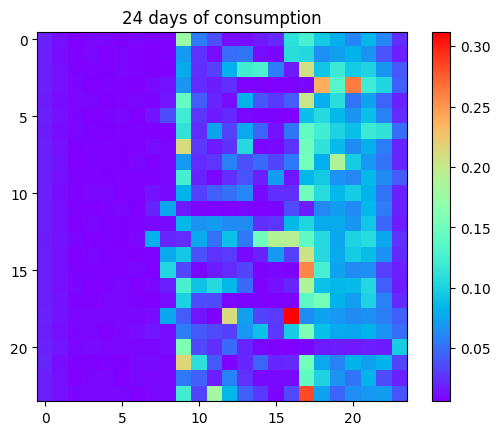

In [50]:
plt.imshow(cons_array_reshaped,cmap = 'rainbow')
plt.title("24 days of consumption")
plt.colorbar()

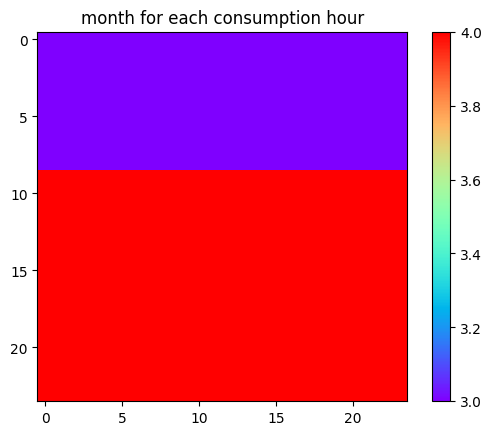

In [51]:
month_first_row = month_for_consumption_days_train.iloc[666].to_numpy()
month_img = month_first_row
for i in range (0,23):
    month_img = np.column_stack((month_img,month_first_row))


plt.imshow(month_img,cmap = 'rainbow')
plt.title("month for each consumption hour")
plt.colorbar()

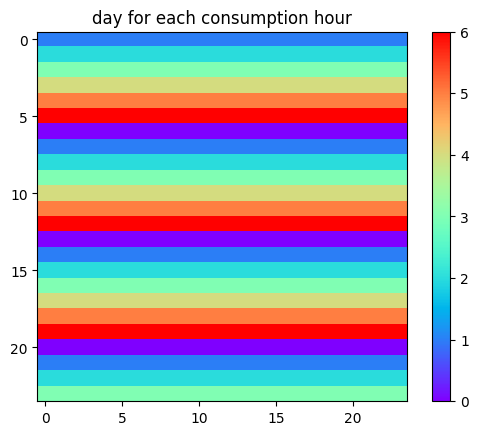

In [52]:
day_first_row = days_for_consumption_days_train.iloc[666].to_numpy()
day_img = day_first_row
for i in range (0,23):
    day_img = np.column_stack((day_img,day_first_row))


plt.imshow(day_img,cmap = 'rainbow')
plt.title("day for each consumption hour")
plt.colorbar()

In [59]:
month_img.min()

3

In [53]:
## Normalize day and month image (method 2 and 3)
month_norm = (month_img)*0.1
dow_norm = (day_img)*0.1


In [54]:
dow_img.max()

6

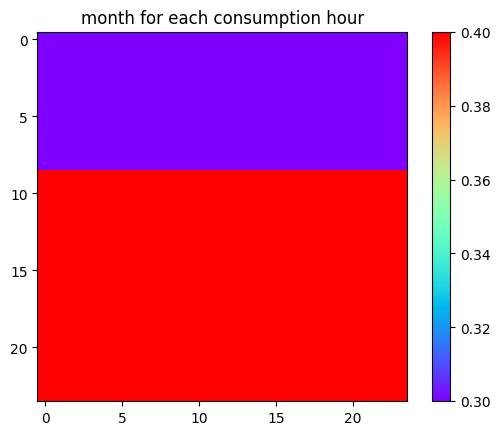

In [55]:

plt.imshow(month_norm,cmap = 'rainbow')
plt.title("month for each consumption hour")
plt.colorbar()


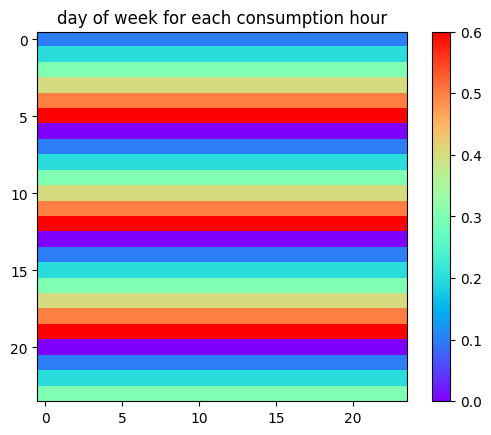

In [56]:
plt.imshow(dow_norm,cmap = 'rainbow')
plt.title("day of week for each consumption hour")
plt.colorbar()


In [59]:
def save_method3_images(consumption_images, month_images, days_images, next_day_24_values):
    day_images_ = np.zeros((len(consumption_images), 24, 24))
    month_images_ = np.zeros((len(consumption_images), 24, 24))
    cons_images_ = np.zeros((len(consumption_images), 24, 24))
    
    next_day_24_values_normalized = next_day_24_values.apply(
    normalize_row,
    axis=1)


    next_day_24_values_ = np.zeros((len(consumption_images), 24))

    for row_id in range(0, len(consumption_images)):

        # days of week
        dow_row = days_images.iloc[row_id].to_numpy()
        dow_img = dow_row
        for i in range(0, 23):
            dow_img = np.column_stack((dow_img, dow_row))

        # months
        month_row = month_images.iloc[row_id].to_numpy()
        month_img = month_row
        for i in range(0, 23):
            month_img = np.column_stack((month_img, month_row))

        # cons
        cons_array = consumption_images.iloc[row_id].to_numpy()
        cons_array_reshaped = np.reshape(cons_array, (-1, 24))

        month_norm = (month_img)*0.1
        dow_norm = (day_img)*0.1    

        # add each image in their corresponding array
        day_images_[row_id] = dow_norm
        month_images_[row_id] = month_norm
        cons_images_[row_id] = cons_array_reshaped

        #print (next_day_24_values[row_id])
        next_day_24_values_[row_id] = next_day_24_values_normalized.iloc[row_id]

        # plt.imshow(rgb)

    all_img_3_channels_ = np.concatenate((np.expand_dims(cons_images_, axis=3),
                                          np.expand_dims(month_images_, axis=3),
                                          np.expand_dims(day_images_, axis=3)), axis=3)
    return (all_img_3_channels_,next_day_24_values_)

### numpy arrays n-dimensionals for neural netwoks

In [60]:
(all_img_3_channels_train,next_day_24_values_train) = save_method3_images(data_consumptions_train,month_for_consumption_days_train,days_for_consumption_days_train,data_consumptions_nexd_day_train)

In [61]:
(all_img_3_channels_val,next_day_24_values_val) = save_method3_images(data_consumptions_val,month_for_consumption_days_val,days_for_consumption_days_val,data_consumptions_nexd_day_val)

In [62]:
(all_img_3_channels_test,next_day_24_values_test) = save_method3_images(data_consumptions_test,month_for_consumption_days_test,days_for_consumption_days_test,data_consumptions_nexd_day_test)

In [65]:
all_img_3_channels_val.shape

(24595, 24, 24, 3)

## Train Deep Learning model

In [66]:

img_width = 24
img_height = 24

num_img_channels = 3

num_epoch = 10

dl = deep_learning.DeepLearning(
    img_width = img_width,
    img_height = img_height,
    img_channels = num_img_channels,
    epochs = num_epoch,
    #num_classes =  len(data.next_day_cluster.unique())
    class_names = "", #not used
    num_classes = 0 #not used
)

GPU setting

In [30]:
aux.set_gpu()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17655571307506614043
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 8657973603717930016
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


2024-05-09 16:27:08.197526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-09 16:27:08.197566: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Set tensor board control panel

In [21]:
from datetime import datetime
log_dir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [22]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

In [23]:
%load_ext tensorboard

In [24]:
# Define the basic TensorBoard callback.
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

2024-05-09 16:06:20.171669: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-09 16:06:20.171795: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-09 16:06:20.171805: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-09 16:06:20.172459: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-09 16:06:20.173264: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


--- Add confussion matrix. Not used for regression!!)

In [12]:

def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image


In [13]:

def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

In [14]:

def log_confusion_matrix(epoch, logs):
    
    y_pred = []  # store predicted labels
    y_true = []  # store true labels
    
    # iterate over the dataset
    for image_batch, label_batch in dl.val_ds:   # use dataset.unbatch() with repeat
       # append true labels
       y_true.append(label_batch)
       # compute predictions
       predicted = model.predict(image_batch)
       # append predicted labels
       y_pred.append(np.argmax(predicted, axis = - 1)) 
        
    correct_labels = tf.concat([item for item in y_true], axis = 0)
    predicted_labels = tf.concat([item for item in y_pred], axis = 0)
        
    #mCalculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(np.argmax(correct_labels,axis=1), predicted_labels)
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=dl.val_ds.class_names)
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Define the per-epoch callback.
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

### save numpy arrays (methodology 3) -images and labels-

In [72]:
np.save('../data/images_train.npy', all_img_3_channels_train) 
np.save('../data/labels_train.npy',next_day_24_values_train) 

np.save('../data/images_val.npy', all_img_3_channels_val) 
np.save('../data/labels_val.npy',next_day_24_values_val) 

np.save('../data/images_test.npy', all_img_3_channels_test) 
np.save('../data/labels_test.npy',next_day_24_values_test) 

In [2]:
all_img_3_channels_train = np.load('../data/images_train.npy') 
next_day_24_values_train = np.load('../data/labels_train.npy')

all_img_3_channels_val = np.load('../data/images_val.npy') 
next_day_24_values_val= np.load('../data/labels_val.npy')

all_img_3_channels_test = np.load('../data/images_test.npy') 
next_day_24_values_test = np.load('../data/labels_test.npy')

In [75]:
next_day_24_values_test

array([[0.00140206, 0.00073441, 0.00073441, ..., 0.00073441, 0.0009347 ,
        0.0020697 ],
       [0.00333823, 0.0009347 , 0.00073441, ..., 0.00073441, 0.00146882,
        0.00367205],
       [0.00126853, 0.00073441, 0.00073441, ..., 0.00073441, 0.00146882,
        0.00367205],
       ...,
       [0.06609694, 0.03825611, 0.01575644, ..., 0.08852984, 0.05401255,
        0.02483643],
       [0.02723995, 0.04553345, 0.01535586, ..., 0.10021365, 0.05721725,
        0.11329951],
       [0.06215783, 0.04266257, 0.01588997, ..., 0.0855922 , 0.11683803,
        0.0535452 ]])

### Model build (3 channel nd array)

In [31]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, Input, Rescaling


input_shape = (24,24,3)
inputs = Input(input_shape)

## DA
#model.add(dl.data_augmentation)
###



outputs = Conv2D(4, kernel_size=(9,9), activation='relu')(inputs)

outputs = Conv2D(5, kernel_size=(5,5), activation='relu')(outputs)

outputs = Conv2D(6, kernel_size=(5,5), activation='relu')(outputs)

outputs = MaxPool2D()(outputs)

outputs = Conv2D(7, kernel_size=(1,1), activation='relu')(outputs)

outputs = MaxPool2D()(outputs)

outputs = Conv2D(8, kernel_size=(1,1), activation='relu')(outputs)

outputs = Flatten()(outputs)

outputs = Dense(64, activation='relu')(outputs)

outputs = Dense(32, activation='relu')(outputs)

outputs = Dense(1)(outputs)

model = tf.keras.Model(inputs, outputs)

#from keras.optimizers import SGD
#opt = SGD(learning_rate=0.001)
#model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['r2_score'])

In [256]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, Input, Rescaling


input_shape = (24,24,3)
inputs = Input(input_shape)

## DA
#model.add(dl.data_augmentation)
###

outputs = Conv2D(64, kernel_size=(3,3), activation='relu')(inputs)
outputs = MaxPool2D()(outputs)

outputs = Flatten()(outputs)

outputs = Dense(64, activation='relu')(outputs)
outputs = Dropout(0.1)(outputs)

outputs = Dense(1)(outputs)

model = tf.keras.Model(inputs, outputs)

#from keras.optimizers import SGD
#opt = SGD(learning_rate=0.001)
#model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['r2_score'])

### Model build (3 channel rbh images

### Model build (method 3) -24 hour prediction-

### Model backbone

In [32]:
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 24, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 4)      │           976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 5)      │           505 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 6)        │           756 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 6)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 7)        │            49 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 7)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 8)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,575 (25.68 KB)

 Trainable params: 6,575 (25.68 KB)

 Non-trainable params: 0 (0.00 B)

### Train 24 deep learning models for 24 next day hourly forecast (with numpy ndarray)

In [331]:
%tensorboard --logdir logs/image
numModels = 24
models = []
for i in range(numModels): 
    models[i] = model.fit(all_img_3_channels_train, next_day_24_values_train[:,i], 
                     validation_data=(all_img_3_channels_val, next_day_24_values_val[:,i]),
                     epochs=5,
                     batch_size=128,
                     callbacks=[[[tensorboard_callback]]])

Reusing TensorBoard on port 6006 (pid 48196), started 2:20:07 ago. (Use '!kill 48196' to kill it.)

Epoch 1/5
 51/774 ━━━━━━━━━━━━━━━━━━━━ 2:47 231ms/step - loss: 0.0025 - r2_score: -0.1535

KeyboardInterrupt: 

### with numpy nd array 3 channels

In [35]:
# Probando modelo para la hora 0

%tensorboard --logdir logs/image

hist = model.fit( all_img_3_channels_train, next_day_24_values_train[:,16], 
                     validation_data=(all_img_3_channels_val, next_day_24_values_val[:,16]),
                     epochs=10,
                     batch_size=256,
                     callbacks=[[[tensorboard_callback]]])

Reusing TensorBoard on port 6006 (pid 12528), started 0:37:10 ago. (Use '!kill 12528' to kill it.)

Epoch 1/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - loss: 0.0039 - r2_score: 0.5164 - val_loss: 0.0029 - val_r2_score: 0.5943
Epoch 2/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - loss: 0.0030 - r2_score: 0.6389 - val_loss: 0.0028 - val_r2_score: 0.6161
Epoch 3/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - loss: 0.0031 - r2_score: 0.6350 - val_loss: 0.0028 - val_r2_score: 0.6168
Epoch 4/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - loss: 0.0030 - r2_score: 0.6389 - val_loss: 0.0028 - val_r2_score: 0.6057
Epoch 5/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - loss: 0.0030 - r2_score: 0.6441 - val_loss: 0.0028 - val_r2_score: 0.6156
Epoch 6/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - loss: 0.0030 - r2_score: 0.6445 - val_loss: 0.0028 - val_r2_score: 0.6138
Epoch 7/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - loss: 0.0030 - r2_score: 0.6451 - val_loss: 0.0028 - val_r2_score: 0.6177
Epoch 8/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - loss: 0.0029 - r2_score: 0.6549 - 

In [68]:
## de-normalizar

def unnormalize_row(x):
    unnormalized = x * (max_val - min_val) + min_val
    return unnormalized



## Predicions over test (example 15:00 h)

435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


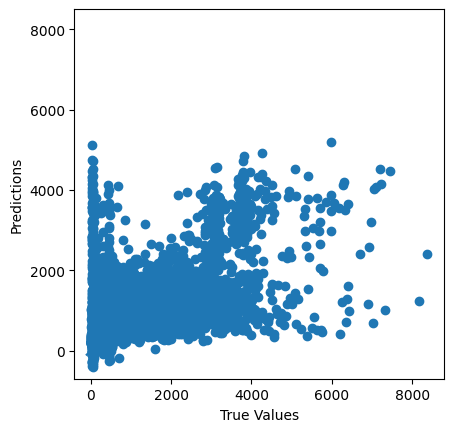

In [69]:


test_predictions = model.predict(all_img_3_channels_test).flatten()


test_predictions_unnormalized = pd.DataFrame(test_predictions).apply(
    unnormalize_row,
    axis=1)

real_values_unnormalized = pd.DataFrame(next_day_24_values_test[:,16]).apply(
    unnormalize_row,
    axis=1)


plt.scatter(real_values_unnormalized, test_predictions_unnormalized)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')

_ = plt.plot([-100, 100], [-100, 100])

In [73]:
next_day_24_values_test

array([[0.00140206, 0.00073441, 0.00073441, ..., 0.00073441, 0.0009347 ,
        0.0020697 ],
       [0.00333823, 0.0009347 , 0.00073441, ..., 0.00073441, 0.00146882,
        0.00367205],
       [0.00126853, 0.00073441, 0.00073441, ..., 0.00073441, 0.00146882,
        0.00367205],
       ...,
       [0.06609694, 0.03825611, 0.01575644, ..., 0.08852984, 0.05401255,
        0.02483643],
       [0.02723995, 0.04553345, 0.01535586, ..., 0.10021365, 0.05721725,
        0.11329951],
       [0.06215783, 0.04266257, 0.01588997, ..., 0.0855922 , 0.11683803,
        0.0535452 ]])

In [70]:
test_predictions_unnormalized

,0
0,209.933594
1,211.325668
2,208.612839
3,210.832397
4,216.258575
...,...
13896,2046.224365
13897,1859.530640
13898,2130.539551
13899,2269.357178


In [71]:
real_values_unnormalized

,0
0,12.0
1,12.0
2,12.0
3,12.0
4,12.0
...,...
13896,1598.0
13897,1250.0
13898,1103.0
13899,1774.0


In [47]:
next_day_24_values_test

array([[0.00140206, 0.00073441, 0.00073441, ..., 0.00073441, 0.0009347 ,
        0.0020697 ],
       [0.00333823, 0.0009347 , 0.00073441, ..., 0.00073441, 0.00146882,
        0.00367205],
       [0.00126853, 0.00073441, 0.00073441, ..., 0.00073441, 0.00146882,
        0.00367205],
       ...,
       [0.06609694, 0.03825611, 0.01575644, ..., 0.08852984, 0.05401255,
        0.02483643],
       [0.02723995, 0.04553345, 0.01535586, ..., 0.10021365, 0.05721725,
        0.11329951],
       [0.06215783, 0.04266257, 0.01588997, ..., 0.0855922 , 0.11683803,
        0.0535452 ]])

In [45]:
test_predictions

array([0.01394937, 0.01404231, 0.01386119, ..., 0.14217784, 0.15144594,
       0.14499825], dtype=float32)

In [42]:
len(next_day_24_values_test)

13901

### with images rgb 3 channels

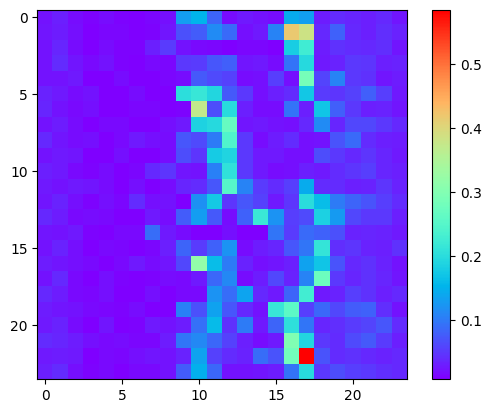

In [112]:
plt.imshow(all_img_3_channels_train[0,:,:,0],cmap='rainbow')
plt.colorbar()

In [113]:
all_img_3_channels_train

array([[[[0.02229937, 0.5       , 0.1       ],
         [0.03151289, 0.5       , 0.1       ],
         [0.01849379, 0.5       , 0.1       ],
         ...,
         [0.03164641, 0.5       , 0.1       ],
         [0.03892375, 0.5       , 0.1       ],
         [0.02523701, 0.5       , 0.1       ]],

        [[0.02503672, 0.5       , 0.2       ],
         [0.02944318, 0.5       , 0.2       ],
         [0.01969555, 0.5       , 0.2       ],
         ...,
         [0.03184671, 0.5       , 0.2       ],
         [0.04206169, 0.5       , 0.2       ],
         [0.03244759, 0.5       , 0.2       ]],

        [[0.02229937, 0.5       , 0.3       ],
         [0.03478435, 0.5       , 0.3       ],
         [0.01709173, 0.5       , 0.3       ],
         ...,
         [0.03792229, 0.5       , 0.3       ],
         [0.04346375, 0.5       , 0.3       ],
         [0.02483643, 0.5       , 0.3       ]],

        ...,

        [[0.03945787, 0.5       , 0.1       ],
         [0.03498464, 0.5       , 0.1       ]

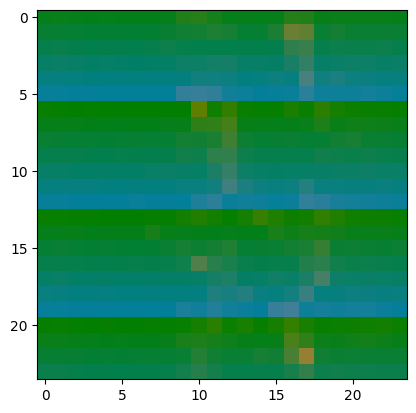

In [95]:
rgb_img = np.dstack((all_img_3_channels_train[0,:,:,0], all_img_3_channels_train[0,:,:,1], all_img_3_channels_train[0,:,:,2]))
plt.imshow(rgb_img,cmap='rainbow')

In [105]:
all_img_3_channels_train[0,:,:,0]

array([[0.02229937, 0.03151289, 0.01849379, 0.0105488 , 0.01849379,
        0.01008145, 0.00874616, 0.01301909, 0.01969555, 0.13092536,
        0.15262385, 0.08278809, 0.01815997, 0.02617172, 0.02236614,
        0.01662438, 0.14354386, 0.13239418, 0.02824142, 0.04085993,
        0.03611964, 0.03164641, 0.03892375, 0.02523701],
       [0.02503672, 0.02944318, 0.01969555, 0.00741087, 0.01361998,
        0.01382027, 0.00741087, 0.01161704, 0.02370143, 0.06623047,
        0.07611163, 0.11370009, 0.0867272 , 0.01929497, 0.0267726 ,
        0.10689011, 0.41821338, 0.38382962, 0.03785552, 0.0814528 ,
        0.03672052, 0.03184671, 0.04206169, 0.03244759],
       [0.02229937, 0.03478435, 0.01709173, 0.00761116, 0.01729203,
        0.01041528, 0.01041528, 0.03024436, 0.05174256, 0.02256643,
        0.01542262, 0.01215116, 0.0075444 , 0.01408733, 0.01355321,
        0.00854587, 0.18126586, 0.2258646 , 0.02810789, 0.04519963,
        0.04112699, 0.03792229, 0.04346375, 0.02483643],
       [0.022

- Prepara labels for image rgb methodology

- Save images on folder train test and val

In [109]:
### Save images
import matplotlib.image as img

for row_id in range(0, len(all_img_3_channels_train)):
    r = all_img_3_channels_train[row_id,:,:,0]
    g = all_img_3_channels_train[row_id,:,:,1]
    b = all_img_3_channels_train[row_id,:,:,2]
    rgb = np.dstack((r, g, b))
    img.imsave(f'../data/images/input/train/{row_id}.png', rgb, cmap="rainbow")
    
for row_id in range(0, len(all_img_3_channels_val)):
    r = all_img_3_channels_val[row_id,:,:,0]
    g = all_img_3_channels_val[row_id,:,:,1]
    b = all_img_3_channels_val[row_id,:,:,2]
    rgb = np.dstack((r, g, b))
    img.imsave(f'../data/images/input/val/{row_id}.png', rgb, cmap="rainbow")
    
for row_id in range(0, len(all_img_3_channels_test)):
    r = all_img_3_channels_test[row_id,:,:,0]
    g = all_img_3_channels_test[row_id,:,:,1]
    b = all_img_3_channels_test[row_id,:,:,2]
    rgb = np.dstack((r, g, b))
    img.imsave(f'../data/images/input/test/{row_id}.png', rgb, cmap="rainbow")
    


- Prepara labels

In [4]:
img_ids =  [*range(0,len(next_day_24_values_train))]
img_ids =  np.char.mod('%d', img_ids)
labels = next_day_24_values_train[:,13]
names = ["id","score"]

train_label_df = pd.DataFrame(
    {'id': img_ids,
     'score': labels,
    })
train_label_df


,id,score
0,0,0.071772
1,1,0.044198
2,2,0.023835
3,3,0.148952
4,4,0.027841
...,...,...
99008,99008,0.111897
99009,99009,0.134664
99010,99010,0.009547
99011,99011,0.005809


In [5]:
img_ids = [*range(0,len(next_day_24_values_val))]
img_ids =  np.char.mod('%d', img_ids)
labels = next_day_24_values_val[:,13]
names = ["id","score"]

val_label_df = pd.DataFrame(
    {'id': img_ids,
     'score': labels,
    })
val_label_df

,id,score
0,0,0.025103
1,1,0.019629
2,2,0.021431
3,3,0.100347
4,4,0.032514
...,...,...
24590,24590,0.037255
24591,24591,0.044999
24592,24592,0.021164
24593,24593,0.041728


In [6]:
val_label_df['id'] = val_label_df['id'].astype(str) + '.png'
train_label_df['id'] = train_label_df['id'].astype(str) + '.png'

In [259]:
val_label_df['score'] = val_label_df['score'].astype('float')
train_label_df['score'] = train_label_df['score'].astype('float')

In [251]:
train_label_df

,id,score
0,0.png,0.071772
1,1.png,0.044198
2,2.png,0.023835
3,3.png,0.148952
4,4.png,0.027841
...,...,...
99008,99008.png,0.111897
99009,99009.png,0.134664
99010,99010.png,0.009547
99011,99011.png,0.005809


In [9]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(
#       rescale=1./255,
#       rotation_range=40,
#       width_shift_range=0.2,
      # height_shift_range=0.2,
      # shear_range=0.2,
      # zoom_range=0.2,
      # horizontal_flip=True,
      # fill_mode='nearest')
      

train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)


train_generator_ = train_datagen.flow_from_dataframe(
    dataframe=train_label_df,
    directory='../data/images/train/train',
    x_col="id",
    y_col="score",
    color_mode="rgb",
    class_mode="other", 
    target_size=(24, 24),
    batch_size=32
)

valid_generator_ = val_datagen.flow_from_dataframe(
    dataframe=val_label_df,
    directory='../data/images/val/val',
    x_col="id",
    y_col="score",
    class_mode="other", 
    color_mode="rgb",
    target_size=(24, 24),
    batch_size=32
)



Found 99013 validated image filenames.
Found 24483 validated image filenames.


/Users/fran/venv-tfmetal/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 112 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


In [27]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, Input, Rescaling


input_shape = (24,24,3)
inputs = Input(input_shape)

## DA
#model.add(dl.data_augmentation)
###

model = tf.keras.Sequential()
model.add(inputs)
model.add (Conv2D(4, kernel_size=(9,9), activation='relu'))
model.add (Conv2D(5, kernel_size=(5,5), activation='relu'))
model.add (Conv2D(6, kernel_size=(5,5), activation='relu'))
model.add (MaxPool2D())
model.add (Conv2D(7, kernel_size=(1,1), activation='relu'))
model.add (MaxPool2D())
model.add (Conv2D(8, kernel_size=(1,1), activation='relu'))
model.add (Flatten())
model.add (Dense(128))
model.add (Dense(64))
model.add (Dense(1))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['r2_score'])

In [29]:

%tensorboard --logdir logs/image

hist = model.fit(
    x = train_generator_, 
    validation_data = valid_generator_,
    epochs=10,
    batch_size=32,
    callbacks=[[[tensorboard_callback]]]
)

Reusing TensorBoard on port 6006 (pid 12528), started 0:14:58 ago. (Use '!kill 12528' to kill it.)

Epoch 1/10


2024-05-09 16:21:35.253062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/fran/venv-tfmetal/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-09 16:22:08.399536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 1 of 8
2024-05-09 16:22:47.359113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 2 of 8
2024-05-09 16:23:10.625951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer 

AttributeError: 'NoneType' object has no attribute 'items'

In [327]:
model.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 24, 24, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 22, 22, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │       495,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,492,613 (5.69 MB)

 Trainable params: 497,537 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 995,076 (3.80 MB)

In [140]:
model.save('corrientes_model.keras')